## Lightning 

In [54]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torchmetrics
import torchvision
from IPython.core.display import display
from kornia import image_to_tensor, tensor_to_image
from kornia.augmentation import ColorJitter, RandomChannelShuffle, RandomHorizontalFlip, RandomThinPlateSpline
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import StochasticWeightAveraging
from pytorch_lightning.loggers import CSVLogger

from torch import Tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from sklearn.metrics import ConfusionMatrixDisplay

sn.set()

In [22]:
class DataAugmentation(nn.Module):
    """Module to perform data augmentation using Kornia on torch tensors."""

    def __init__(self, apply_color_jitter: bool = False) -> None:
        super().__init__()
        self._apply_color_jitter = apply_color_jitter

        self.transforms = nn.Sequential(
            RandomHorizontalFlip(p=0.75),
            RandomChannelShuffle(p=0.75),
            RandomThinPlateSpline(p=0.75),
        )

        self.jitter = ColorJitter(0.5, 0.5, 0.5, 0.5)

    @torch.no_grad()  # disable gradients for effiency
    def forward(self, x: Tensor) -> Tensor:
        x_out = self.transforms(x)  # BxCxHxW
        if self._apply_color_jitter:
            x_out = self.jitter(x_out)
        return x_out

In [23]:
class Preprocess(nn.Module):
    """Module to perform pre-process using Kornia on torch tensors."""

    @torch.no_grad()  # disable gradients for effiency
    def forward(self, x) -> Tensor:
        x_tmp: np.ndarray = np.array(x)  # HxWxC
        x_out: Tensor = image_to_tensor(x_tmp, keepdim=True)  # CxHxW
        return x_out.float() / 255.0

In [49]:
class CoolSystem(LightningModule):
    def __init__(self):
        super().__init__()
        # not the best model: expereiment yourself
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)
        self.preprocess = Preprocess()  # per sample transforms
        self.transform = DataAugmentation()  # per batch augmentation_kornia
        self.train_accuracy = torchmetrics.Accuracy()
        self.val_accuracy = torchmetrics.Accuracy()
        
        self.n_classes = 10
        
        self.train_cm = torchmetrics.ConfusionMatrix(num_classes=self.n_classes)
        self.valid_cm = torchmetrics.ConfusionMatrix(num_classes=self.n_classes)
        

    def forward(self, x):
        return self.model(x)

    def compute_loss(self, y_hat, y):
        y = F.one_hot(y, self.n_classes)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = evidence_loss.edl_mse_loss(y_hat, y, self.current_epoch, self.n_classes, 5)
   
        #return F.cross_entropy(y_hat, y)
        return loss

    def show_batch(self, win_size=(10, 10)):
        def _to_vis(data):
            return tensor_to_image(torchvision.utils.make_grid(data, nrow=8))

        # get a batch from the training set: try with `val_datlaoader` :)
        imgs, labels = next(iter(self.train_dataloader()))
        imgs_aug = self.transform(imgs)  # apply transforms
        # use matplotlib to visualize
        plt.figure(figsize=win_size)
        plt.imshow(_to_vis(imgs))
        plt.figure(figsize=win_size)
        plt.imshow(_to_vis(imgs_aug))

    def on_after_batch_transfer(self, batch, dataloader_idx):
        x, y = batch
        if self.trainer.training:
            x = self.transform(x)  # => we perform GPU/Batched data augmentation
        return x, y

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        self.train_accuracy.update(y_hat, y)
        self.log("train_loss", loss, prog_bar=False)
        self.log("train_acc", self.train_accuracy, prog_bar=False)
        y_hat = y_hat.argmax(dim=1, keepdim=True)
        self.train_cm(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        self.val_accuracy.update(y_hat, y)
        self.log("valid_loss", loss, prog_bar=False)
        self.log("valid_acc", self.val_accuracy, prog_bar=True)
        y_hat = y_hat.argmax(dim=1, keepdim=True)
        self.valid_cm(y_hat, y)
        
    def validation_epoch_end(self, outputs):
        # turn confusion matrix into a figure (Tensor cannot be logged as a scalar)
        fig, ax = plt.subplots(figsize=(8,8))
        #plt.imshow(self.valid_cm.compute().cpu().numpy())
        disp = ConfusionMatrixDisplay(self.valid_cm.compute().cpu().numpy())
        disp.plot(ax=ax)
        
        # log figure
        self.logger.experiment.add_figure('valid_epoch_confmat', fig, global_step=self.global_step)
    
        self.valid_cm.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, self.trainer.max_epochs, 0)
        return [optimizer], [scheduler]

    def prepare_data(self):
        CIFAR10(os.getcwd(), train=True, download=True, transform=self.preprocess)
        CIFAR10(os.getcwd(), train=False, download=True, transform=self.preprocess)

    def train_dataloader(self):
        dataset = CIFAR10(os.getcwd(), train=True, download=True, transform=self.preprocess)
        loader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=int(16/2))
        return loader

    def val_dataloader(self):
        dataset = CIFAR10(os.getcwd(), train=False, download=True, transform=self.preprocess)
        loader = DataLoader(dataset, batch_size=256, shuffle=False, num_workers=int(16/2))
        return loader

In [50]:
# init model
model = CoolSystem()

In [45]:
batch = next(iter(model.val_dataloader()))

Files already downloaded and verified


In [46]:
y = model(batch[0])
y.shape

torch.Size([256, 10])

In [47]:
batch[1].shape

torch.Size([256])

### Visualize images

Files already downloaded and verified


/home/deebuls/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


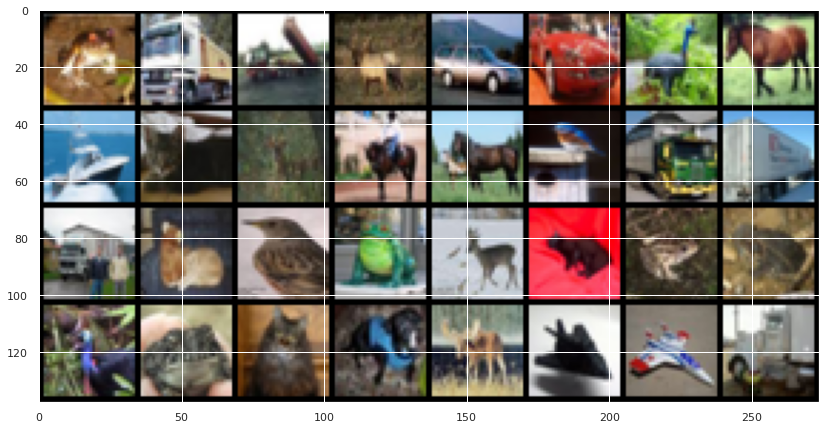

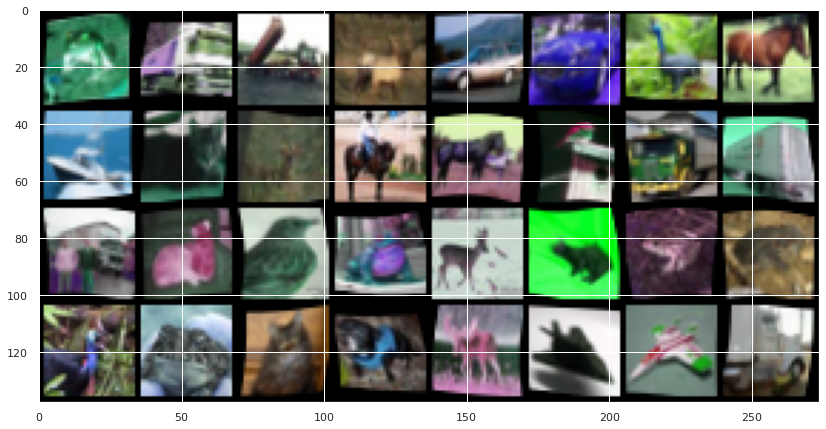

In [26]:
model.show_batch(win_size=(14, 14))

### Trainining

In [57]:
# Initialize a trainer
trainer = Trainer(
    callbacks=[TQDMProgressBar(refresh_rate=20),
               StochasticWeightAveraging(swa_lrs=1e-2)],
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=50,
)

# Train the model ⚡
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | model          | ResNet           | 11.2 M
1 | preprocess     | Preprocess       | 0     
2 | transform      | DataAugmentation | 0     
3 | train_accuracy | Accuracy         | 0     
4 | val_accuracy   | Accuracy         | 0     
5 | train_cm       | ConfusionMatrix  | 0     
6 | valid_cm       | ConfusionMatrix  | 0     
----------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Swapping scheduler `CosineAnnealingLR` for `SWALR`


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Catalyst

In [3]:
import os
from pathlib import Path
from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CIFAR10
import torchvision.models as models
import torchvision.transforms as transforms

from catalyst import dl, metrics, utils
#from catalyst.data.transforms import ToTensor
from catalyst.contrib.data.transforms import ImageToTensor

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /home/deebuls/Documents/phd/blender-dataset/SemanticTemporalFusion/semantic_segmentation_notebooks/cifar-10-python.tar.gz to /home/deebuls/Documents/phd/blender-dataset/SemanticTemporalFusion/semantic_segmentation_notebooks


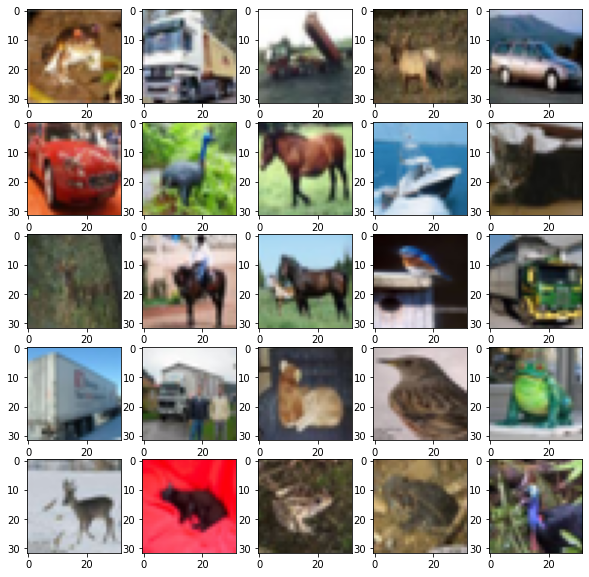

In [9]:
import matplotlib.pyplot as plt
import os


cifar_dataset = CIFAR10(os.getcwd(), train=True, download=True)

_, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(25):
    ax[i // 5, i % 5].imshow(cifar_dataset[i][0], cmap="gray")

In [10]:
cifar_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # ImageNet normalizer
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
        ),
    ]
)

loaders = {
    "train": DataLoader(
        CIFAR10(
            os.getcwd(), train=True, download=True, transform=cifar_transform
        ),
        batch_size=256,
    ),
    "valid": DataLoader(
        CIFAR10(
            os.getcwd(), train=False, download=True, transform=cifar_transform
        ),
        batch_size=256,
    ),
}

Files already downloaded and verified
Files already downloaded and verified


In [11]:
class CIFARrunner(dl.Runner):

    def predict_batch(self, batch):
        # model inference step
        return self.model(batch[0].to(self.device))

    def handle_batch(self, batch):
        # model train/valid step
        x, y = batch
        y_pred = self.model(x)

        self.batch = {"features": x, "logits": y_pred, "targets": y}

In [18]:
from catalyst.contrib.optimizers.lookahead import Lookahead

net = models.resnet18(pretrained=False)
net.fc = nn.Linear(net.fc.in_features, 10)
optimizer = Lookahead(torch.optim.Adam(net.parameters(), lr=1e-3))
criterion = nn.CrossEntropyLoss()

runner = CIFARrunner()
# model training


# model training
runner.train(
    model=net,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    logdir="./lightning_logs/",
    num_epochs=5,
    verbose=True,
    callbacks=[
        dl.AccuracyCallback(input_key="logits", target_key="targets", topk=(1, 3)),
        dl.PrecisionRecallF1SupportCallback(
            input_key="logits", target_key="targets", num_classes=10
        ),
        dl.CriterionCallback(input_key="logits", target_key="targets", metric_key="loss"),
        dl.BackwardCallback(metric_key="loss"),
        dl.OptimizerCallback(metric_key="loss"),
        dl.CheckpointCallback(
            "./lightning_logs/", loader_key="valid", metric_key="loss", minimize=True, topk=3
        ),
    ]
)

# model evaluation
metrics = runner.evaluate_loader(
    loader=loaders["valid"],
    callbacks=[dl.AccuracyCallback(input_key="logits", target_key="targets", topk=(1, 3, 5))],
)

1/5 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (1/5) accuracy01: 0.5017400000572204 | accuracy01/std: 0.08293154534095401 | accuracy03: 0.8102200000381465 | accuracy03/std: 0.07484394939051661 | f1/_macro: 0.49918245082013274 | f1/_micro: 0.5017350000498261 | f1/_weighted: 0.4991824508201327 | loss: 1.3905428386688228 | loss/mean: 1.3905428386688228 | loss/std: 0.23622897561848585 | lr: 0.001 | momentum: 0.9 | precision/_macro: 0.4978221032211426 | precision/_micro: 0.5017400000000001 | precision/_weighted: 0.4978221032211426 | recall/_macro: 0.50174 | recall/_micro: 0.5017400000000001 | recall/_weighted: 0.50174


1/5 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (1/5) accuracy01: 0.609 | accuracy01/std: 0.02983593082638494 | accuracy03: 0.8848 | accuracy03/std: 0.019845481458342876 | f1/_macro: 0.6043886543222461 | f1/_micro: 0.6089950000410504 | f1/_weighted: 0.6043886543222461 | loss: 1.1034607790946962 | loss/mean: 1.1034607790946962 | loss/std: 0.06767494191190761 | lr: 0.001 | momentum: 0.9 | precision/_macro: 0.6071794351191432 | precision/_micro: 0.609 | precision/_weighted: 0.6071794351191432 | recall/_macro: 0.6089999999999999 | recall/_micro: 0.609 | recall/_weighted: 0.609
* Epoch (1/5) 


2/5 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (2/5) accuracy01: 0.6488000000190733 | accuracy01/std: 0.038443491826434105 | accuracy03: 0.9044400000190735 | accuracy03/std: 0.02171438650010456 | f1/_macro: 0.647602983304525 | f1/_micro: 0.6487950000385324 | f1/_weighted: 0.647602983304525 | loss: 0.9840769799995432 | loss/mean: 0.9840769799995432 | loss/std: 0.10094099848450644 | lr: 0.001 | momentum: 0.9 | precision/_macro: 0.6469209438689703 | precision/_micro: 0.6488 | precision/_weighted: 0.6469209438689704 | recall/_macro: 0.6487999999999999 | recall/_micro: 0.6488 | recall/_weighted: 0.6488000000000002


2/5 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (2/5) accuracy01: 0.6432999999999999 | accuracy01/std: 0.029888531787848723 | accuracy03: 0.8965 | accuracy03/std: 0.01771872654360443 | f1/_macro: 0.6423931785130408 | f1/_micro: 0.6432950000388618 | f1/_weighted: 0.6423931785130409 | loss: 1.0227148301124573 | loss/mean: 1.0227148301124573 | loss/std: 0.07645889217552654 | lr: 0.001 | momentum: 0.9 | precision/_macro: 0.6621724958927062 | precision/_micro: 0.6433 | precision/_weighted: 0.6621724958927061 | recall/_macro: 0.6433 | recall/_micro: 0.6433 | recall/_weighted: 0.6433
* Epoch (2/5) 


3/5 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (3/5) accuracy01: 0.7312599999809264 | accuracy01/std: 0.03290881802565985 | accuracy03: 0.938260000019074 | accuracy03/std: 0.017134308377312064 | f1/_macro: 0.7304177470851685 | f1/_micro: 0.7312550000341873 | f1/_weighted: 0.7304177470851685 | loss: 0.7613013719177247 | loss/mean: 0.7613013719177247 | loss/std: 0.08547420330254381 | lr: 0.001 | momentum: 0.9 | precision/_macro: 0.7298466337729745 | precision/_micro: 0.73126 | precision/_weighted: 0.7298466337729747 | recall/_macro: 0.73126 | recall/_micro: 0.73126 | recall/_weighted: 0.73126


3/5 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (3/5) accuracy01: 0.6384000000000001 | accuracy01/std: 0.026505499507657192 | accuracy03: 0.8936000000000001 | accuracy03/std: 0.016374654589678923 | f1/_macro: 0.6382144279224523 | f1/_micro: 0.6383950000391602 | f1/_weighted: 0.6382144279224523 | loss: 1.0838972558975217 | loss/mean: 1.0838972558975217 | loss/std: 0.0882839124324545 | lr: 0.001 | momentum: 0.9 | precision/_macro: 0.6741218927153942 | precision/_micro: 0.6384000000000001 | precision/_weighted: 0.6741218927153942 | recall/_macro: 0.6384000000000001 | recall/_micro: 0.6384000000000001 | recall/_weighted: 0.6384000000000001
* Epoch (3/5) 


4/5 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (4/5) accuracy01: 0.7915199999999998 | accuracy01/std: 0.032320676315980026 | accuracy03: 0.95996 | accuracy03/std: 0.013587295252987146 | f1/_macro: 0.7911129090677979 | f1/_micro: 0.7915150000315845 | f1/_weighted: 0.7911129090677979 | loss: 0.5916155479717257 | loss/mean: 0.5916155479717257 | loss/std: 0.07666888447710701 | lr: 0.001 | momentum: 0.9 | precision/_macro: 0.7908720308143318 | precision/_micro: 0.79152 | precision/_weighted: 0.7908720308143319 | recall/_macro: 0.79152 | recall/_micro: 0.79152 | recall/_weighted: 0.7915200000000001


4/5 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (4/5) accuracy01: 0.6114 | accuracy01/std: 0.031904171555084494 | accuracy03: 0.8827999999999998 | accuracy03/std: 0.0182681313347109 | f1/_macro: 0.6176205069505223 | f1/_micro: 0.6113950000408893 | f1/_weighted: 0.6176205069505223 | loss: 1.255984173965454 | loss/mean: 1.255984173965454 | loss/std: 0.10909324225774668 | lr: 0.001 | momentum: 0.9 | precision/_macro: 0.6463777474064301 | precision/_micro: 0.6113999999999999 | precision/_weighted: 0.6463777474064301 | recall/_macro: 0.6113999999999999 | recall/_micro: 0.6113999999999999 | recall/_weighted: 0.6114
* Epoch (4/5) 


5/5 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (5/5) accuracy01: 0.8349400000190729 | accuracy01/std: 0.031428200442774085 | accuracy03: 0.97354 | accuracy03/std: 0.011690509328518037 | f1/_macro: 0.834757550223306 | f1/_micro: 0.8349350000299421 | f1/_weighted: 0.8347575502233061 | loss: 0.4695917163705822 | loss/mean: 0.4695917163705822 | loss/std: 0.08079926526954909 | lr: 0.001 | momentum: 0.9 | precision/_macro: 0.8346601137394742 | precision/_micro: 0.83494 | precision/_weighted: 0.8346601137394742 | recall/_macro: 0.8349399999999999 | recall/_micro: 0.83494 | recall/_weighted: 0.83494


5/5 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (5/5) accuracy01: 0.6121000000000002 | accuracy01/std: 0.030524253438942644 | accuracy03: 0.8677999999999999 | accuracy03/std: 0.02012066373435308 | f1/_macro: 0.6189221830426639 | f1/_micro: 0.6120950000408426 | f1/_weighted: 0.618922183042664 | loss: 1.4291132986068724 | loss/mean: 1.4291132986068724 | loss/std: 0.14641300868350698 | lr: 0.001 | momentum: 0.9 | precision/_macro: 0.6592737389964715 | precision/_micro: 0.6121 | precision/_weighted: 0.6592737389964715 | recall/_macro: 0.6121 | recall/_micro: 0.6121 | recall/_weighted: 0.6121
* Epoch (5/5) 
Top models:
./lightning_logs//model.0002.pth	1.0227
./lightning_logs//model.0003.pth	1.0839
./lightning_logs//model.0001.pth	1.1035
valid (1/1) accuracy01: 0.6121000000000002 | accuracy01/std: 0.030524253438942644 | accuracy03: 0.8677999999999999 | accuracy03/std: 0.02012066373435308 | accuracy05: 0.9555999999999999 | accuracy05/std: 0.012645394046808502
* Epoch (1/1) 


## Evidential Catalyst

In [ ]:

class EvidentialCIFARRunner(dl.Runner):
    def on_loader_start(self, runner):
        super().on_loader_start(runner)
        self.meters = {
            key: metrics.AdditiveMetric(compute_on_call=False)
            for key in ["loss", "mae"]
        }

    def handle_batch(self, batch):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `train()`.
        x, y = batch

        y_pred = self.model(x) # Forward pass

        # Compute the loss value
        loss = F.mse_loss(y_pred, y)
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask, self.epoch, self.n_classes, 10)
   

        # Update metrics (includes the metric that tracks the loss)
        self.batch_metrics.update({"loss": loss, "mae": F.l1_loss(y_pred, y)})
        for key in ["loss", "mae"]:
            self.meters[key].update(self.batch_metrics[key].item(), self.batch_size)

        if self.is_train_loader:
            # Compute gradients
            loss.backward()
            # Update weights
            # (the optimizer is stored in `self.state`)
            self.optimizer.step()
            self.optimizer.zero_grad()
    
    def on_loader_end(self, runner):
        for key in ["loss", "mae"]:
            self.loader_metrics[key] = self.meters[key].compute()[0]
        super().on_loader_end(runner)

In [20]:
from catalyst.contrib.optimizers.lookahead import Lookahead
import evidence_loss

net = models.resnet18(pretrained=False)
net.fc = nn.Linear(net.fc.in_features, 10)
optimizer = Lookahead(torch.optim.Adam(net.parameters(), lr=1e-3))
criterion = evidence_loss.edl_mse_loss

runner = CIFARrunner()
# model training


# model training
runner.train(
    model=net,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    logdir="./lightning_logs/",
    num_epochs=5,
    verbose=True,
    callbacks=[
        dl.AccuracyCallback(input_key="logits", target_key="targets", topk=(1, 3)),
        dl.PrecisionRecallF1SupportCallback(
            input_key="logits", target_key="targets", num_classes=10
        ),
        dl.CriterionCallback(input_key="logits", target_key="targets", metric_key="loss"),
        dl.BackwardCallback(metric_key="loss"),
        dl.OptimizerCallback(metric_key="loss"),
        dl.CheckpointCallback(
            "./lightning_logs/", loader_key="valid", metric_key="loss", minimize=True, topk=3
        ),
    ]
)

# model evaluation
metrics = runner.evaluate_loader(
    loader=loaders["valid"],
    callbacks=[dl.AccuracyCallback(input_key="logits", target_key="targets", topk=(1, 3, 5))],
)

1/5 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

TypeError: edl_mse_loss() missing 3 required positional arguments: 'epoch_num', 'num_classes', and 'annealing_step'